In [ ]:
import re
import json
from typing import List, Dict, Any
from collections import defaultdict

# ----------------- Component -------------------------------------
class Component:
    """Light‐weight representation for any parsed component line."""
    def __init__(self, raw_label: str, channel: int, mux_chr: str, constants: Dict[str, Any]):
        self.label = raw_label.strip()
        self.type = self._infer_type(self.label)
        self.channel = channel
        self.mux_chr = mux_chr
        self.global_idx = (ord(mux_chr) - ord('A')) * 16 + channel
        self.id = f"{self.type}_{mux_chr}{channel}"
        # flat constants for this component/regulator
        self.constants = constants.get(self.label, {})
        # regulator helpers
        self.is_regulator = self.type in ("activator", "repressor", "inducer", "inhibitor")
        if self.is_regulator:
            self.is_floating = self.label.startswith("floating_")
            self.position = (
                "start" if self.label.endswith("_start")
                else "end" if self.label.endswith("_end")
                else None
            )
            self.reg_key = self.label.rsplit("_", 1)[0]  # e.g. "repressor_a"
        else:
            self.is_floating = False
            self.position = None
            self.reg_key = None
        # will be filled in by builder
        self.parameters: Dict[str, Any] = {}
        self.circuit_name: str | None = None

    @staticmethod
    def _infer_type(label: str) -> str:
        lc = label.lower()
        if lc.startswith("promoter"):
            return "promoter"
        if lc.startswith("rbs"):
            return "rbs"
        if lc.startswith("cds"):
            return "cds"
        if lc.startswith("terminator"):
            return "terminator"
        parts = lc.split("_")
        if len(parts) >= 3 and parts[0] in ("activator","repressor","inducer","inhibitor") and parts[-1] in ("start","end"):
            return parts[0]
        return "misc"

    def to_dict(self):
        return {
            "id": self.id,
            "name": self.label,
            "type": self.type,
            "parameters": self.parameters
        }

# ----------------- Ontology Builder ------------------------------
class OntologyBuilderUnified:
    def __init__(self, constants: Dict[str, Any]):
        # flat constants: component_name → param dict
        self.constants = constants
        self.items: List[Component|None] = []
        self.circuits: List[Dict[str,Any]] = []
        self.comp_to_circuit: Dict[str,str] = {}
        self.valid_comp_ids: set[str] = set()

        # regulator registry
        self.regulators: Dict[str,Dict[str,Any]] = defaultdict(lambda: {
            "starts": [], "ends": [], "type": None, "is_floating": False
        })
        self.regulations: List[Dict[str,Any]] = []
        self.regulator_issues: List[Dict[str,str]] = []
        self.unpaired_regulators: List[Dict[str,str]] = []

        # extras & misplaced
        self.extra_components_found = {
            "within_valid_circuits": [],
            "outside_of_valid_circuits": [],
            "misplaced_components": []
        }

    # -------------- PARSE -----------------------------------------
    def parse_text_file(self, lines: List[str]):
        self.items = []
        def extract(raw: str):
            m = re.search(r"\['([^']+)'\]", raw)
            return m.group(1) if m else None

        mux_counter = 0
        in_circ = False
        has_cds = False

        for raw in lines:
            lbl = extract(raw)
            if lbl is None:
                # blank or unrecognized → circuit break
                self.items.append(None)
                in_circ = False
                has_cds = False
                continue

            comp = Component(lbl, mux_counter % 16, chr(65 + mux_counter // 16), self.constants)
            mux_counter += 1

            # break circuit on new promoter after seeing a CDS
            if in_circ and has_cds and comp.type == "promoter":
                self.items.append(None)
                in_circ = False
                has_cds = False

            self.items.append(comp)
            in_circ = True
            if comp.type == "cds":
                has_cds = True

            # register regulator starts/ends
            if comp.is_regulator and comp.position:
                rec = self.regulators[comp.reg_key]
                rec["type"] = comp.type
                rec["is_floating"] = comp.is_floating
                rec[f"{comp.position}s"].append(comp)

    # -------------- BUILD -----------------------------------------
    def build(self):
        block: List[Component] = []
        for itm in self.items + [None]:
            if itm is None:
                if block:
                    self._finalize_block(block)
                    block = []
                continue
            block.append(itm)

        self._detect_unpaired_regulators()
        self._build_regulations()

        # Add constitutive regulations to self.regulations with source=None
        for circ in self.circuits:
            cds_names = [c["name"] for c in circ["components"] if c["type"] == "cds"]
            for name in cds_names:
                has_reg = any(
                    reg for reg in self.regulations
                    if name in reg.get("affected_cdss", [])
                )
                if not has_reg:
                    # Find nearest upstream promoter for this CDS
                    cds_idx = next(i for i, c in enumerate(circ["components"]) if c["name"] == name)
                    prom_name = None
                    for i in range(cds_idx - 1, -1, -1):
                        if circ["components"][i]["type"] == "promoter":
                            prom_name = circ["components"][i]["name"]
                            break
                    if prom_name:
                        self.regulations.append({
                            "type": "constitutive",
                            "source": None,
                            "target": prom_name,
                            "parameters": {
                                "type": "constitutive"
                            },
                            "affected_cdss": [name]
                        })



        # Add constitutive regulations to self.regulations
        for circ in self.circuits:
            cds_names = [c["name"] for c in circ["components"] if c["type"] == "cds"]
            prom = next((c["name"] for c in circ["components"] if c["type"] == "promoter"), None)
            for name in cds_names:
                has_reg = any(
                    reg for reg in self.regulations
                    if name in reg.get("affected_cdss", [])
                )
                if not has_reg and prom:
                    self.regulations.append({
                        "type": "constitutive",
                        "source": name,
                        "target": prom,
                        "parameters": {
                            "type": "constitutive"
                        },
                        "affected_cdss": [name]
                    })


        # Tag CDSs without any regulation as constitutive (after regulations are built)
        for circ in self.circuits:
            cds_names = [c["name"] for c in circ["components"] if c["type"] == "cds"]
            constitutive = []
            for name in cds_names:
                has_reg = any(
                    reg for reg in self.regulations
                    if name in reg.get("affected_cdss", [])
                )
                if not has_reg:
                    constitutive.append(name)
                    
            if constitutive:
                for c in circ["components"]:
                    if c["type"] == "cds" and c["name"] in constitutive:
                        c["regulation"] = "constitutive"

        self._detect_extras_outside()

    # -------------- finalize circuit ------------------------------
    def _finalize_block(self, comps: List[Component]):
        # 1) fill comp.parameters from flat constants
        for comp in comps:
            params = self.constants.get(comp.label, {})
            if comp.type == "promoter":
                comp.parameters["strength"] = params.get("strength", 1.0)
            elif comp.type == "rbs":
                comp.parameters["efficiency"] = params.get("efficiency", 1.0)
            elif comp.type == "terminator":
                comp.parameters["efficiency"] = params.get("efficiency", 0.99)
            elif comp.type == "cds":
                comp.parameters["translation_rate"] = params.get("translation_rate", 5.0)
                comp.parameters["degradation_rate"]  = params.get("degradation_rate", 0.1)
                comp.parameters["init_conc"] = params.get("init_conc", 0.01)
                
        # skip if no CDS
        if not any(c.type == "cds" for c in comps):
            return

        # assign circuit name
        name = f"circuit_{len(self.circuits)+1}"
        for c in comps:
            c.circuit_name = name
            self.comp_to_circuit[c.id] = name
            self.valid_comp_ids.add(c.id)

        # detect duplicates & misplacements
        extras = []
        misplaced = []
        last_seen = None
        first_prom = first_rbs = first_cds = False
        last_rbs_name = None
        cds_to_rbs: Dict[str,Any] = {}
        
        from collections import defaultdict
        type_counts = defaultdict(int)

        for comp in comps:
            t = comp.type
            # misplaced rules
            if t == "promoter" and first_cds:
                misplaced.append({**comp.to_dict(), "reason":"Promoter after CDS"})
            elif t == "rbs" and first_cds and not first_rbs:
                misplaced.append({**comp.to_dict(), "reason":"First RBS after CDS"})
            elif t == "terminator" and not first_cds:
                misplaced.append({**comp.to_dict(), "reason":"Terminator before CDS"})
            elif t == "cds" and (not first_prom or not first_rbs):
                misplaced.append({**comp.to_dict(), "reason":"CDS does not have a promoter and/or RBS before it!"})

            
            # ---------- duplicate / extra rules (flag any duplicate in circuit) ----------
            if t in ("promoter", "terminator", "rbs"):
                type_counts[t] += 1             # first = 1 (normal), second = 2 (duplicate)
                if type_counts[t] > 1:
                    extras.append({**comp.to_dict(),
                                   "reason": f"Extra {t} in circuit"})

            # bookkeeping
            if t=="promoter":
                first_prom = True
            elif t=="rbs":
                first_rbs = True
                last_rbs_name = comp.label
            elif t=="cds":
                cds_to_rbs[comp.label] = last_rbs_name
                first_cds = True

            if t != "misc":
                last_seen = t

        # fallbacks per CDS
        fb_by_cds = {}
        has_term = any(c.type=="terminator" for c in comps)
        for comp in comps:
            if comp.type!="cds":
                continue
            fb = {}
            if not first_prom:
                fb["missing_promoter"] = True; fb["prom_strength"] = 0.01
            if not first_rbs:
                fb["missing_rbs"] = True; fb["rbs_efficiency"] = 0.01
            if not has_term:
                fb["missing_terminator"] = True; fb["degradation_rate"] = 0.01
            if fb:
                fb_by_cds[comp.label] = fb

        # assemble circuit dict
        circ = {
            "name": name,
            "modelable": True,
            "components": [c.to_dict() for c in comps],
            "cds_to_rbs": cds_to_rbs
        }
        if fb_by_cds:
            circ["fallback_by_cds"] = fb_by_cds
                # Tag CDSs with no regulators as constitutive

        self.circuits.append(circ)

        if extras:
            self.extra_components_found["within_valid_circuits"].append({
                "circuit": name, "extras": extras
            })
        if misplaced:
            self.extra_components_found["misplaced_components"].append({
                "circuit": name, "misplaced": misplaced
            })

    # -------------- unpaired regulators --------------------------
    def _detect_unpaired_regulators(self):
        for key, rec in self.regulators.items():
            if not rec["starts"] or not rec["ends"]:
                self.unpaired_regulators.append({
                    "label": key,
                    "issue": "Regulator missing start or end.",
                    "hint":  "Place start or end on board!"
                })

    # -------------- nearest non‐regulator helper ------------------
    def _nearest_prev_non_reg(self, comp: Component):
        idx = self.items.index(comp)
        for j in range(idx-1, -1, -1):
            it = self.items[j]
            if it is None: break
            if isinstance(it, Component) and not it.is_regulator:
                return it
        return None

    # -------------- downstream CDS helper -----------------------
    def _downstream_cds(self, circuit_name: str, idx_threshold: int) -> List[str]:
        names: List[str] = []
        for circ in self.circuits:
            if circ["name"] != circuit_name:
                continue
            for comp in circ["components"]:
                if comp["type"] == "cds":
                    obj = next(
                        (it for it in self.items
                         if isinstance(it, Component)
                         and it.label == comp["name"]),
                        None
                    )
                    if obj and obj.global_idx > idx_threshold:
                        names.append(obj.label)  # human-readable name
            break
        return names


    # -------------- build regulations --------------------------
    def _build_regulations(self):
        type_map = {
            "activator": "transcriptional_activation",
            "repressor": "transcriptional_repression",
            "inducer":   "induced_activation",
            "inhibitor": "environmental_repression"
        }
        self_map = {
            "activator": "self_activation",
            "repressor": "self_repression",
            "inducer":   "self_activation",
            "inhibitor": "self_repression"
        }

        for key, rec in self.regulators.items():
            starts, ends = rec["starts"], rec["ends"]
            if not starts or not ends:
                continue

            for end in ends:
                prom_prev = self._nearest_prev_non_reg(end)
                if not prom_prev or prom_prev.type!="promoter":
                    self.regulator_issues.append({
                        "label": end.label,
                        "issue": "Regulator end not immediately after promoter.",
                        "hint":  "Place regulator end after the promoter you want to regulate!"
                    })
                    continue

                affected = self._downstream_cds(end.circuit_name, prom_prev.global_idx)

                for start in starts:
                    if rec["is_floating"] and start.circuit_name is not None:
                        self.regulator_issues.append({
                            "label": start.label,
                            "issue": "Floating start inside circuit.",
                            "hint":  "Move floating regulator's start to be outside of all circuits!"
                        })

                    # determine source CDS (or key) for non‐floating
                    if not rec["is_floating"]:
                        src_prev = self._nearest_prev_non_reg(start)
                        if not src_prev or src_prev.type!="cds":
                            self.regulator_issues.append({
                                "label": start.label,
                                "issue": "Regulator start does not follow a CDS.",
                                "hint":  "Place regulator start after the CDS you want to be the source!"
                            })
                            continue
                        source_name = src_prev.label
                    else:
                        source_name = key

                    # choose regulation kind
                    # Determine regulation kind based on circuit context

                    if rec["is_floating"] and start.circuit_name is None:
                        # Floating regulator placed outside all circuits → induced/environmental regulation
                        kind = type_map.get(rec["type"], "transcriptional_regulation")
                    elif start.circuit_name != end.circuit_name:
                        # Start and end span two different circuits → transcriptional activation/repression
                        kind = type_map.get(rec["type"], "transcriptional_regulation")
                    else:
                        # Within same circuit → self activation/repression
                        kind = self_map.get(rec["type"])

                    # pull real regulator constants from flat JSON
                    base = self.constants.get(start.reg_key, {})
                    real_params = {
                        "type":        rec["type"],
                        "is_floating": rec["is_floating"]
                    }
                    for p in ("Ka","Kr","n","concentration"):
                        if p in base:
                            real_params[p] = base[p]

                    self.regulations.append({
                        "type":           kind,
                        "source":         source_name,
                        "target":         prom_prev.label,
                        "parameters":     real_params,
                        "affected_cdss":  [] if rec["is_floating"] else affected
                    })

    # -------------- extras outside circuits -----------------------
    def _detect_extras_outside(self):
        for itm in self.items:
            if (isinstance(itm,Component)
                and itm.type in ("promoter","rbs","cds","terminator")
                and itm.id not in self.valid_comp_ids):
                self.extra_components_found["outside_of_valid_circuits"].append({
                    **itm.to_dict(),
                    "reason": "Core part not part of any circuit."
                })

    # -------------- export ----------------------------
    def export(self) -> Dict[str,Any]:
        return {
            "cell": {
                "circuits":             self.circuits,
                "regulations":          self.regulations,
                "regulator_issues":     self.regulator_issues,
                "unpaired_regulators":  self.unpaired_regulators,
                "extra_components_found": self.extra_components_found
            }
        }

# ------------------------- main runner ----------------------------
if __name__ == "__main__":
    with open("constants_realistic_ordered.json") as fp:
        consts = json.load(fp)
    with open("test.originalversion (no spaces).txt") as fp:
        lines = fp.readlines()

    builder = OntologyBuilderUnified(consts)
    builder.parse_text_file(lines)
    builder.build()

    with open("ontology_output_adjusted.json","w") as fp:
        json.dump(builder.export(), fp, indent=2)
    print("✅ Ontology written to ontology_output_adjusted.json")


✅ Ontology written to ontology_output_adjusted.json



--- Symbolic ODEs (Text) ---
d[Protein A]/dt = 0.01 + (5.000×0.010)·(1) - 1.0·[Protein A]
d[Protein B]/dt = 0.01 + (5.000×0.010)·(1) - 1.0·[Protein B]
d[Protein C]/dt = 0.01 + (5.000×1.000)·(1) - 1.0·[Protein C]
d[Protein D]/dt = 0.01 + (5.000×1.000)·(1) - 1.0·[Protein D]
d[Protein E]/dt = 0.01 + (5.000×1.000)·(K_r^2/(K_r^2+[\mathrm{Protein A}]^2) × [\mathrm{Protein B}]^2/(K_a^2+[\mathrm{Protein B}]^2)) - 1.0·[Protein E]
d[Protein G]/dt = 0.01 + (5.000×1.000)·(K_r^2/(K_r^2+[\mathrm{Protein E}]^2)) - 1.0·[Protein G]

--- Symbolic ODEs (LaTeX) ---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

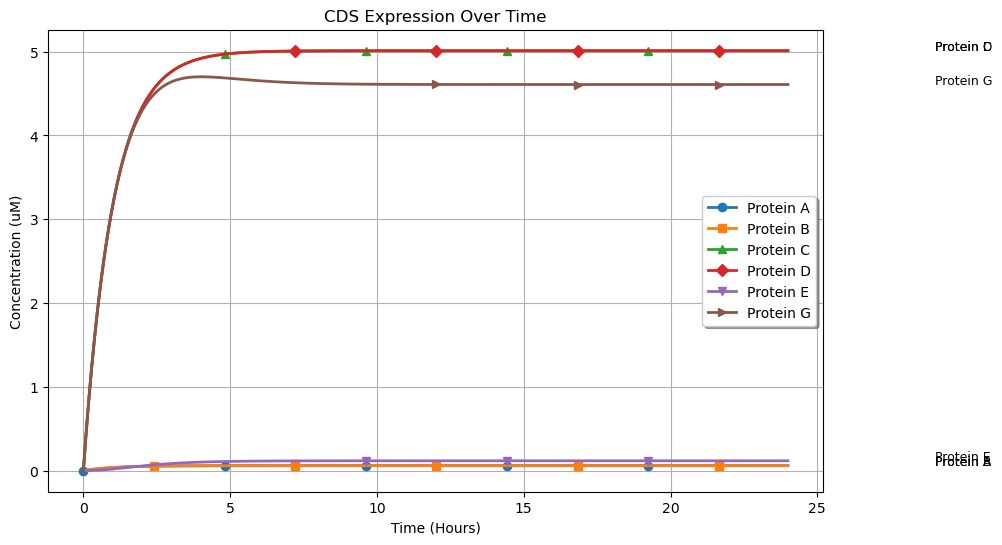

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import display, Math
from collections import defaultdict

# ─── Helper for LaTeX‐safe names ─────────────────────────
def safe_tex(var: str) -> str:
    return var.replace('_', r'\\_')

# ─── 1. Load ontology ────────────────────────────────────
with open("ontology_output_adjusted.json") as f:
    cell = json.load(f)["cell"]

# ─── 2. Parameters ───────────────────────────────────────
basal_constitutive = 0.01     # k0 for constitutive (no regulators)
initial_conc_default        = 0.01    # *back-up* initial [protein] for all CDS species

# ─── 3. Gather CDS entries + display names ─────────────
cds_list      = []
display_names = []
id2comp       = {}
id2circ       = {}

for circ in cell["circuits"]:
    if not circ.get("modelable", False):
        continue
    comps = circ["components"]
    # … your existing base_prom logic …
   # determine base promoter strength
    first_cds_idx = next((i for i,c in enumerate(comps) if c["type"] == "cds"), None)
    if first_cds_idx is not None:
        prom_idxs = [i for i,c in enumerate(comps) if c["type"] == "promoter" and i < first_cds_idx]
        base_prom = comps[max(prom_idxs)]["parameters"].get("strength", 0.0) if prom_idxs else 0.01
    else:
        base_prom = 0.01
    circ["_base_prom"] = base_prom
    
    for comp in comps:
        if comp["type"] != "cds": continue
        cds_id = comp["id"]
        letter = comp["name"].split("_")[-1].upper()
        cds_list.append(cds_id)
        display_names.append(f"Protein {letter}")
        id2comp[cds_id] = comp
        id2circ[cds_id] = circ

# ─── 3.5 Build name→ID mapping for all components ────────
# (so we can translate 'cds_a' into 'cds_A5', etc.)
name2id = {
    comp["name"]: comp["id"]
    for circ in cell["circuits"]
    for comp in circ["components"]
}

# ─── 4. Group regulations by CDS ID ──────────────────────
regs_by_cds = defaultdict(list)
for reg in cell.get("regulations", []):
    for tgt_name in reg.get("affected_cdss", []):
        tgt_id = name2id.get(tgt_name)
        if tgt_id:
            regs_by_cds[tgt_id].append(reg)


# ─── 5. Build per‐CDS parameters & symbolic equations ────
cds_params     = {}
symbolic_text  = {}
symbolic_latex = {}

for i, cds_id in enumerate(cds_list):
    disp = display_names[i]  # human‐readable label
    
    comp = id2comp[cds_id]
    circ = id2circ[cds_id]
    base_prom = circ["_base_prom"]

    # RBS efficiency (name‐based lookup)
    rbs_name = circ["cds_to_rbs"].get(comp["name"])
    if rbs_name:
        rbs_comp = next((c for c in circ["components"] if c["name"] == rbs_name), None)
        base_rbs = rbs_comp["parameters"]["efficiency"] if rbs_comp else 0.01
    else:
        base_rbs = 0.01

    # Fallback & effective rates
    fb     = circ.get("fallback_by_cds", {}).get(comp["name"], {})
    prom_s = fb.get("prom_strength", base_prom)
    rbs_e  = fb.get("rbs_efficiency", base_rbs)
    degr   = fb.get("degradation_rate", comp["parameters"]["degradation_rate"])

    # Numeric parameters
    kprod = prom_s * rbs_e
    k0    = basal_constitutive if not regs_by_cds.get(cds_id) else 0.01

    cds_params[cds_id] = {
        "k0":            k0,
        "prom_strength": prom_s,
        "rbs_eff":       rbs_e,
        "kprod":         kprod,
        "degradation":   degr, 
        # NEW — default initial level, overridable later #
        "initial_conc":  comp["parameters"].get(
            "init_conc",
            initial_conc_default
        )
    }

    # Build symbolic Hill factors
    text_fs, latex_fs = [], []
    for reg in regs_by_cds.get(cds_id, []):
        typ = reg["type"]
        pr  = reg["parameters"]
        n   = pr.get("n", 2)
        src_name = reg["source"]
        src_id = name2id.get(src_name)

        if src_id in cds_list:
            src_disp = display_names[cds_list.index(src_id)]
            src_tex = f"\\mathrm{{{src_disp}}}"
        else:
            src_tex = str(pr.get("concentration", 1.0))

        if typ in ("transcriptional_activation", "self_activation", "induced_activation"):
            text_fs .append(f"[{src_tex}]^{n}/(K_a^{n}+[{src_tex}]^{n})")
            latex_fs.append(rf"\frac{{[{src_tex}]^{n}}}{{K_a^{n}+[{src_tex}]^{n}}}")
        elif typ in ("transcriptional_repression", "self_repression", "environmental_repression"):
            text_fs .append(f"K_r^{n}/(K_r^{n}+[{src_tex}]^{n})")
            latex_fs.append(rf"\frac{{K_r^{n}}}{{K_r^{n}+[{src_tex}]^{n}}}")

    tf = " × ".join(text_fs)    if text_fs  else "1"
    lf = r" \times ".join(latex_fs) if latex_fs else "1"

    # **Use disp** (e.g. “Protein A”) instead of cds_id here
    eq_txt = (
        f"d[{disp}]/dt = {k0}"
        f" + ({prom_s:.3f}×{rbs_e:.3f})·({tf})"
        f" - {degr}·[{disp}]"
    )
    eq_tex = (
        rf"\frac{{d[\mathrm{{{disp}}}]}}{{dt}} = {k0}"
        rf" + ({prom_s:.3f}\times{rbs_e:.3f})\,({lf})"
        rf" - {degr}\,[\mathrm{{{disp}}}]"
    )

    symbolic_text[cds_id]  = eq_txt
    symbolic_latex[cds_id] = eq_tex

# ─── 6. Display symbolic equations once ───────────────────
print("\n--- Symbolic ODEs (Text) ---")
for cds_id, disp in zip(cds_list, display_names):
    print(symbolic_text[cds_id])

print("\n--- Symbolic ODEs (LaTeX) ---")
for cds_id in cds_list:
    display(Math(symbolic_latex[cds_id]))

# ─── 7. Define RHS (no display calls) ────────────────────
def rhs(p, t):
    dpdt = np.zeros(len(cds_list))
    for i, cds_id in enumerate(cds_list):
        pars = cds_params[cds_id]
        f_vals = []

        for reg in regs_by_cds.get(cds_id, []):
            typ = reg["type"]
            
            if typ == "constitutive":
                f_vals.append(1.0)          # always “on”
                continue                    # skip source lookup
          
            pr  = reg["parameters"]
            n   = pr.get("n", 2)

            # Resolve the value of the regulator
            src_name = reg["source"]
            src_id = name2id.get(src_name)

            if src_id in cds_list:
                val = p[cds_list.index(src_id)]  # Use protein concentration
            elif typ in ("induced_activation", "environmental_repression"):
                val = pr.get("concentration", 1.0)  # Use constant for floating
            else:
                raise ValueError(f"Cannot resolve source {src_name} for regulation type {typ}")

            # Apply correct regulation function
            if typ in ("transcriptional_activation", "self_activation", "induced_activation"):
                Ka = pr.get("Ka", 0.5)
                f_vals.append(val**n / (Ka**n + val**n))
            elif typ in ("transcriptional_repression", "self_repression", "environmental_repression"):
                Kr = pr.get("Kr", 0.5)
                f_vals.append(Kr**n / (Kr**n + val**n))

        # Combine regulation effects and compute final rate
        f_prod = np.prod(f_vals) if f_vals else 1.0
        dpdt[i] = pars["k0"] + pars["kprod"] * f_prod - pars["degradation"] * p[i]

    return dpdt

# ─── Extra step to set p0 values as a vector  ───────────────
def def_initial_conc(cds_list, cds_params, overrides=None):
  
    overrides = overrides or {}
    p0 = np.zeros(len(cds_list))

    for i, cds_id in enumerate(cds_list):
        p0[i] = overrides.get(
            cds_id,
            cds_params[cds_id].get("initial_conc", initial_conc_default)
        )

    return p0

# ─── 8. Simulate & plot ───────────────────────────────────
t  = np.linspace(0, 24, 500)
p0 = def_initial_conc(cds_list, cds_params)
sol = odeint(rhs, p0, t)

plt.figure(figsize=(10, 6))
markers = ['o', 's', '^', 'D', 'v', '>', '<', '*']
for i, label in enumerate(display_names):
    offset = (i * 50) % len(t)
    plt.plot(t, sol[:, i], marker=markers[i%len(markers)],
             markevery=(offset,100), linewidth=2, label=label)
    plt.text(t[-1]+5, sol[-1,i], label, fontsize=9)
plt.xlabel("Time (Hours)"); plt.ylabel("Concentration (uM)")
plt.title("CDS Expression Over Time")
plt.legend(shadow=True);
plt.grid(); 

plt.show();


In [ ]:
 import re
-import json
-import base64
-import numpy as np
-from io import BytesIO
-from typing import List, Dict, Any, Optional
+from typing import Any, Dict, List, Optional
 from collections import defaultdict
-import logging
+
 import matplotlib
 matplotlib.use('Agg')
 import matplotlib.pyplot as plt
 
+
 class Component:
     """Light-weight representation for any parsed component line."""
-    
-    def __init__(self, raw_label: str, channel: int, mux_chr: str, constants: Dict[str, Any], strength: str = 'norm'):
+
+    def __init__(self, raw_label: str, channel: int, mux_chr: str, constants: Dict[str, Any], strength: str = "norm"):
         self.label = raw_label.strip()
         self.type = self._infer_type(self.label)
         self.channel = channel
         self.mux_chr = mux_chr
         self.global_idx = (ord(mux_chr) - ord('A')) * 16 + channel
         self.id = f"{self.type}_{mux_chr}{channel}"
-        self.strength = strength  # Store strength parameter
-        
+        self.strength = strength
+
         # Flat constants for this component/regulator
         self.constants = constants.get(self.label, {})
-        
+
         # Regulator helpers
         self.is_regulator = self.type in ("activator", "repressor", "inducer", "inhibitor")
         if self.is_regulator:
             self.is_floating = self.label.startswith("floating_")
-            # Extract position from label like "repressor_start_2" or "repressor_start2"
             parts = self.label.lower().split("_")
             if len(parts) >= 2:
-                # Handle both formats: "repressor_start_2" and "repressor_start2"
                 if len(parts) >= 3:
-                    # Format: repressor_start_2 (gene number is separate)
                     position_part = parts[1]
                     gene_part = parts[2]
                 else:
-                    # Format: repressor_start2 (gene number attached to position)
                     position_part = parts[1]
                     gene_part = ""
-                
-                # Extract position
+
                 if position_part.startswith("start"):
                     self.position = "start"
-                    if not gene_part:  # Extract from combined format
+                    if not gene_part:
                         gene_part = position_part[len("start"):]
                 elif position_part.startswith("end"):
                     self.position = "end"
-                    if not gene_part:  # Extract from combined format
+                    if not gene_part:
                         gene_part = position_part[len("end"):]
                 else:
                     self.position = None
-                    
-                # Create regulator key
+
                 if self.position and gene_part:
                     self.reg_key = f"{parts[0]}_{gene_part}"
                 elif self.position:
                     self.reg_key = f"{parts[0]}"
                 else:
                     self.reg_key = None
             else:
                 self.position = None
                 self.reg_key = None
         else:
             self.is_floating = False
             self.position = None
             self.reg_key = None
-        
-        # Will be filled in by builder
+
         self.parameters: Dict[str, Any] = {}
         self.circuit_name: Optional[str] = None
 
     @staticmethod
     def _infer_type(label: str) -> str:
         lc = label.lower()
         if lc.startswith("promoter"):
             return "promoter"
         if lc.startswith("rbs"):
             return "rbs"
         if lc.startswith("cds"):
             return "cds"
         if lc.startswith("terminator"):
             return "terminator"
-        
-        # Check for regulator patterns: activator_start_2, repressor_end_3, etc.
+
         parts = lc.split("_")
         if len(parts) >= 2:
             reg_type = parts[0]
             position_part = parts[1]
-            
-            # Handle both formats: "repressor_start_2" and "repressor_start2"
             if position_part.startswith("start") or position_part.startswith("end"):
-                position = "start" if position_part.startswith("start") else "end"
                 if reg_type in ("activator", "repressor", "inducer", "inhibitor"):
                     return reg_type
         return "misc"
 
-    def to_dict(self):
-        return {
+    def to_dict(self) -> Dict[str, Any]:
+        data = {
             "id": self.id,
             "name": self.label,
             "type": self.type,
-            "parameters": self.parameters
+            "parameters": self.parameters,
         }
+        if self.strength is not None:
+            data["strength"] = self.strength
+        return data
+
 
 class OntologyBuilderUnified:
-    """Enhanced ontology builder from Version 15.3 with comprehensive circuit analysis"""
-    
+    """Unified ontology builder that assembles circuits and regulatory relationships."""
+
     def __init__(self, constants: Dict[str, Any]):
-        # Flat constants: component_name → param dict
         self.constants = constants
+        self._reset_analysis_state()
+
+    def _reset_analysis_state(self) -> None:
         self.items: List[Optional[Component]] = []
         self.circuits: List[Dict[str, Any]] = []
         self.comp_to_circuit: Dict[str, str] = {}
         self.valid_comp_ids: set[str] = set()
-
-        # Regulator registry
         self.regulators: Dict[str, Dict[str, Any]] = defaultdict(lambda: {
-            "starts": [], "ends": [], "type": None, "is_floating": False
+            "starts": [],
+            "ends": [],
+            "type": None,
+            "is_floating": False,
         })
         self.regulations: List[Dict[str, Any]] = []
         self.regulator_issues: List[Dict[str, str]] = []
         self.unpaired_regulators: List[Dict[str, str]] = []
-
-        # Extras & misplaced
         self.extra_components_found = {
             "within_valid_circuits": [],
             "outside_of_valid_circuits": [],
-            "misplaced_components": []
+            "misplaced_components": [],
         }
 
-    def parse_text_file(self, lines: List[str]):
-        """Parse component lines in hardware txt file format"""
-        self.items = []
-        
-        def extract_component(raw: str):
-            # Extract component name from ['component_name']
-            m = re.search(r"\['([^']+)'\]", raw)
-            return m.group(1) if m else None
-        
-        def extract_strength(raw: str):
-            # Extract strength from strength=value
-            m = re.search(r"strength=(\w+)", raw)
-            return m.group(1) if m else 'norm'
-        
-        def extract_mux_channel(raw: str):
-            # Extract MUX and Channel from "MUX A, Channel 0: ['component']"
-            m = re.search(r"MUX\s+([A-Z]),\s+Channel\s+(\d+):", raw)
-            if m:
-                return m.group(1), int(m.group(2))
-            return None, None
+    def parse_text_file(self, lines: List[str]) -> None:
+        self._reset_analysis_state()
 
-        in_circ = False
+        mux_counter = 0
+        in_circuit = False
         has_cds = False
 
+        def extract_component(raw: str) -> Optional[str]:
+            match = re.search(r"\['([^']+)'\]", raw)
+            return match.group(1) if match else None
+
+        def extract_strength(raw: str) -> str:
+            match = re.search(r"strength=([\w.-]+)", raw)
+            return match.group(1) if match else "norm"
+
+        def extract_mux_channel(raw: str) -> tuple[Optional[str], Optional[int]]:
+            match = re.search(r"MUX\s+([A-Z]),\s*Channel\s+(\d+)", raw)
+            if match:
+                return match.group(1), int(match.group(2))
+            return None, None
+
         for raw in lines:
             raw = raw.strip()
             if not raw:
-                # Empty line → circuit break
                 self.items.append(None)
-                in_circ = False
+                in_circuit = False
                 has_cds = False
                 continue
-                
-            lbl = extract_component(raw)
-            if lbl is None:
-                # Blank or unrecognized → circuit break
+
+            label = extract_component(raw)
+            if label is None:
                 self.items.append(None)
-                in_circ = False
+                in_circuit = False
                 has_cds = False
                 continue
 
-            # Extract strength info
             strength = extract_strength(raw)
-
-            # Extract MUX/Channel info for proper hardware indexing
             mux_letter, channel = extract_mux_channel(raw)
-            if mux_letter and channel is not None:
-                comp = Component(lbl, channel, mux_letter, self.constants, strength)
-            else:
-                # Fallback for simple format without MUX/Channel
-                mux_counter = len([x for x in self.items if x is not None])
-                comp = Component(lbl, mux_counter % 16, chr(65 + mux_counter // 16), self.constants, strength)
+            if mux_letter is None or channel is None:
+                mux_letter = chr(65 + (mux_counter // 16))
+                channel = mux_counter % 16
 
-            # Break circuit on new promoter after seeing a CDS
-            if in_circ and has_cds and comp.type == "promoter":
+            comp = Component(label, channel, mux_letter, self.constants, strength=strength)
+            mux_counter += 1
+
+            if in_circuit and has_cds and comp.type == "promoter":
                 self.items.append(None)
-                in_circ = False
+                in_circuit = False
                 has_cds = False
 
             self.items.append(comp)
-            in_circ = True
+            in_circuit = True
             if comp.type == "cds":
                 has_cds = True
 
-            # Register regulator starts/ends
             if comp.is_regulator and comp.position:
-                rec = self.regulators[comp.reg_key]
-                rec["type"] = comp.type
-                rec["is_floating"] = comp.is_floating
-                rec[f"{comp.position}s"].append(comp)
+                record = self.regulators[comp.reg_key]
+                record["type"] = comp.type
+                record["is_floating"] = comp.is_floating
+                record[f"{comp.position}s"].append(comp)
+
+    def build(self) -> None:
+        self.circuits = []
+        self.comp_to_circuit = {}
+        self.valid_comp_ids = set()
+        self.regulations = []
+        self.regulator_issues = []
+        self.unpaired_regulators = []
+        self.extra_components_found = {
+            "within_valid_circuits": [],
+            "outside_of_valid_circuits": [],
+            "misplaced_components": [],
+        }
 
-    def build(self):
-        """Build circuits and analyze regulatory networks"""
         block: List[Component] = []
-        for itm in self.items + [None]:
-            if itm is None:
+        for item in self.items + [None]:
+            if item is None:
                 if block:
                     self._finalize_block(block)
                     block = []
                 continue
-            block.append(itm)
+            block.append(item)
 
         self._detect_unpaired_regulators()
         self._build_regulations()
         self._add_constitutive_regulations()
         self._detect_extras_outside()
 
-    def _finalize_block(self, comps: List[Component]):
-        """Finalize a circuit block with enhanced parameter assignment"""
-        # Fill comp.parameters from flat constants
+    def _finalize_block(self, comps: List[Component]) -> None:
         for comp in comps:
             params = self.constants.get(comp.label, {})
             if comp.type == "promoter":
                 comp.parameters["strength"] = params.get("strength", 1.0)
                 comp.parameters["binding_affinity"] = params.get("binding_affinity", 0.1)
             elif comp.type == "rbs":
                 comp.parameters["efficiency"] = params.get("efficiency", 1.0)
                 comp.parameters["translation_rate"] = params.get("translation_rate", 5.0)
             elif comp.type == "terminator":
                 comp.parameters["efficiency"] = params.get("efficiency", 0.99)
             elif comp.type == "cds":
                 comp.parameters["translation_rate"] = params.get("translation_rate", 5.0)
                 comp.parameters["degradation_rate"] = params.get("degradation_rate", 0.1)
                 comp.parameters["init_conc"] = params.get("init_conc", 0.01)
                 comp.parameters["max_expression"] = params.get("max_expression", 100.0)
 
-        # Skip if no CDS
         if not any(c.type == "cds" for c in comps):
             return
 
-        # Assign circuit name
         name = f"circuit_{len(self.circuits) + 1}"
-        for c in comps:
-            c.circuit_name = name
-            self.comp_to_circuit[c.id] = name
-            self.valid_comp_ids.add(c.id)
-
-        # Detect duplicates & misplacements
-        extras = []
-        misplaced = []
+        for comp in comps:
+            comp.circuit_name = name
+            self.comp_to_circuit[comp.id] = name
+            self.valid_comp_ids.add(comp.id)
+
+        extras: List[Dict[str, Any]] = []
+        misplaced: List[Dict[str, Any]] = []
         type_counts = defaultdict(int)
+        last_rbs_name: Optional[str] = None
+        cds_to_rbs: Dict[str, Optional[str]] = {}
+        first_promoter = False
+        first_rbs = False
+        first_cds = False
 
         for comp in comps:
-            t = comp.type
-            type_counts[t] += 1
-
-            # Enhanced misplacement detection
-            if t == "promoter" and type_counts["cds"] > 0:
-                misplaced.append({**comp.to_dict(), "reason": "Promoter after CDS"})
-            elif t == "rbs" and type_counts["cds"] > 0 and type_counts["rbs"] == 1:
-                misplaced.append({**comp.to_dict(), "reason": "First RBS after CDS"})
-            elif t == "terminator" and type_counts["cds"] == 0:
-                misplaced.append({**comp.to_dict(), "reason": "Terminator before CDS"})
-
-        # After processing all components, detect extras
-        cds_count = type_counts["cds"]
-        rbs_count = type_counts["rbs"]
-        
-        # Add extra components based on final counts
+            comp_type = comp.type
+            type_counts[comp_type] += 1
+
+            if comp_type == "promoter":
+                if first_cds:
+                    misplaced.append({**comp.to_dict(), "reason": "Promoter after CDS"})
+                first_promoter = True
+            elif comp_type == "rbs":
+                if first_cds and not first_rbs:
+                    misplaced.append({**comp.to_dict(), "reason": "First RBS after CDS"})
+                first_rbs = True
+                last_rbs_name = comp.label
+            elif comp_type == "terminator":
+                if not first_cds:
+                    misplaced.append({**comp.to_dict(), "reason": "Terminator before CDS"})
+            elif comp_type == "cds":
+                if not first_promoter or not first_rbs:
+                    misplaced.append({**comp.to_dict(), "reason": "CDS does not have a promoter and/or RBS before it!"})
+                cds_to_rbs[comp.label] = last_rbs_name
+                first_cds = True
+
         if type_counts["promoter"] > 1:
-            # Mark all promoters beyond the first as extra
             promoter_comps = [c for c in comps if c.type == "promoter"]
-            for i in range(1, len(promoter_comps)):
-                extras.append({**promoter_comps[i].to_dict(), "reason": "Extra promoter"})
-                
+            for extra_comp in promoter_comps[1:]:
+                extras.append({**extra_comp.to_dict(), "reason": "Extra promoter"})
+
         if type_counts["terminator"] > 1:
-            # Mark all terminators beyond the first as extra
             terminator_comps = [c for c in comps if c.type == "terminator"]
-            for i in range(1, len(terminator_comps)):
-                extras.append({**terminator_comps[i].to_dict(), "reason": "Extra terminator"})
-                
-        # Enhanced RBS sequence validation
+            for extra_comp in terminator_comps[1:]:
+                extras.append({**extra_comp.to_dict(), "reason": "Extra terminator"})
+
         rbs_comps = [c for c in comps if c.type == "rbs"]
         cds_comps = [c for c in comps if c.type == "cds"]
-        
-        if rbs_count > 0 and cds_count > 0:
-            # Validate RBS sequence patterns
-            extra_rbs = self._validate_rbs_sequence_patterns(comps, rbs_comps, cds_comps)
-            extras.extend(extra_rbs)
-        elif rbs_count > cds_count:
-            # Fallback: if more RBS than CDS, mark excess as extra
-            excess_count = rbs_count - cds_count
-            for i in range(rbs_count - excess_count, rbs_count):
-                extras.append({**rbs_comps[i].to_dict(), "reason": f"Extra RBS (more RBS than CDS)"})
-
-        # Store results
-        self.extra_components_found["within_valid_circuits"].extend(extras)
-        self.extra_components_found["misplaced_components"].extend(misplaced)
-
-        # Detect incomplete circuits and generate fallback parameters
-        fallback_by_cds = {}
-        cds_components = [c for c in comps if c.type == "cds"]
-        
-        for cds_comp in cds_components:
-            fallbacks = {}
-            
-            # Check for missing promoter
-            if type_counts["promoter"] == 0:
+        if rbs_comps and cds_comps:
+            extras.extend(self._validate_rbs_sequence_patterns(comps, rbs_comps, cds_comps))
+        elif len(rbs_comps) > len(cds_comps):
+            excess = len(rbs_comps) - len(cds_comps)
+            for extra_comp in rbs_comps[-excess:]:
+                extras.append({**extra_comp.to_dict(), "reason": "Extra RBS (more RBS than CDS)"})
+
+        fallback_by_cds: Dict[str, Dict[str, Any]] = {}
+        has_terminator = any(c.type == "terminator" for c in comps)
+        for comp in comps:
+            if comp.type != "cds":
+                continue
+            fallbacks: Dict[str, Any] = {}
+            if not first_promoter:
                 fallbacks["missing_promoter"] = True
-                fallbacks["prom_strength"] = 0.01  # Low promoter strength fallback
-                
-            # Check for missing RBS
-            if type_counts["rbs"] == 0:
+                fallbacks["prom_strength"] = 0.01
+            if not first_rbs:
                 fallbacks["missing_rbs"] = True
-                fallbacks["rbs_efficiency"] = 0.01  # Low fallback efficiency
-                
-            # Check for missing terminator
-            if type_counts["terminator"] == 0:
+                fallbacks["rbs_efficiency"] = 0.01
+            if not has_terminator:
                 fallbacks["missing_terminator"] = True
-                fallbacks["degradation_rate"] = 0.01  # Higher degradation without terminator
-                
+                fallbacks["degradation_rate"] = 0.01
             if fallbacks:
-                fallback_by_cds[cds_comp.label] = fallbacks
+                fallback_by_cds[comp.label] = fallbacks
 
-        # Create circuit dict
         circuit_dict = {
             "name": name,
+            "modelable": True,
             "components": [c.to_dict() for c in comps],
+            "cds_to_rbs": {k: v for k, v in cds_to_rbs.items() if v},
             "extras": extras,
             "misplaced": misplaced,
             "component_counts": dict(type_counts),
-            "fallback_by_cds": fallback_by_cds
+            "fallback_by_cds": fallback_by_cds,
         }
         self.circuits.append(circuit_dict)
 
+        if extras:
+            self.extra_components_found["within_valid_circuits"].append({
+                "circuit": name,
+                "extras": extras,
+            })
+        if misplaced:
+            self.extra_components_found["misplaced_components"].append({
+                "circuit": name,
+                "misplaced": misplaced,
+            })
+
     def _validate_rbs_sequence_patterns(self, comps: List[Component], rbs_comps: List[Component], cds_comps: List[Component]) -> List[Dict[str, Any]]:
-        """
-        Validate RBS sequence patterns and detect improper sequencing.
-        Valid patterns:
-        1. Alternating: rbs-cds-rbs-cds-rbs-cds
-        2. Grouped: rbs-cds-cds-cds (single RBS followed by multiple CDS)
-        
-        Invalid pattern:
-        - Multiple RBS before multiple CDS: rbs-rbs-cds-cds
-        """
-        extras = []
-        
-        # Get sequence of RBS and CDS components in order
-        rbs_cds_sequence = [comp for comp in comps if comp.type in ["rbs", "cds"]]
-        
+        extras: List[Dict[str, Any]] = []
+        rbs_cds_sequence = [comp for comp in comps if comp.type in {"rbs", "cds"}]
         if len(rbs_cds_sequence) < 2:
             return extras
-            
-        # Create type sequence string for pattern analysis
+
         types_sequence = [comp.type for comp in rbs_cds_sequence]
-        types_string = "".join(t[0] for t in types_sequence)  # 'r' for rbs, 'c' for cds
-        
-        # Find runs of consecutive RBS followed by runs of consecutive CDS
         i = 0
         while i < len(types_sequence):
             if types_sequence[i] == "rbs":
-                # Count consecutive RBS
                 rbs_start = i
                 while i < len(types_sequence) and types_sequence[i] == "rbs":
                     i += 1
                 rbs_count = i - rbs_start
-                
-                # Check if followed by consecutive CDS
                 if i < len(types_sequence) and types_sequence[i] == "cds":
                     cds_start = i
                     while i < len(types_sequence) and types_sequence[i] == "cds":
                         i += 1
                     cds_count = i - cds_start
-                    
-                    # Invalid pattern: multiple RBS before multiple CDS
                     if rbs_count > 1 and cds_count > 1:
-                        # Mark all RBS except the first one as extra
                         for j in range(rbs_start + 1, rbs_start + rbs_count):
-                            extra_rbs_comp = rbs_cds_sequence[j]
-                            extras.append({
-                                **extra_rbs_comp.to_dict(), 
-                                "reason": "Invalid RBS sequence (multiple RBS before multiple CDS)"
-                            })
+                            extra = rbs_cds_sequence[j]
+                            extras.append({**extra.to_dict(), "reason": "Invalid RBS sequence (multiple RBS before multiple CDS)"})
                 else:
-                    # Single step if not followed by CDS
-                    if i == rbs_start:  # Avoid infinite loop
-                        i += 1
+                    i += 1
             else:
                 i += 1
-        
         return extras
 
-    def _detect_unpaired_regulators(self):
-        """Detect regulators without proper start/end pairs"""
-        for reg_key, reg_data in self.regulators.items():
-            starts = reg_data["starts"]
-            ends = reg_data["ends"]
-            reg_type = reg_data.get("type", "unknown")
-            
+    def _detect_unpaired_regulators(self) -> None:
+        for key, record in self.regulators.items():
+            starts = record["starts"]
+            ends = record["ends"]
+            reg_type = record.get("type", "unknown")
             if len(starts) != len(ends):
                 if len(starts) > len(ends):
                     issue = f"Missing {len(starts) - len(ends)} end element(s)"
-                    hint = f"Add {reg_type.replace('_start', '_end')} element(s) to complete the regulation"
+                    hint = "Add corresponding end element(s) to complete the regulation"
                 else:
-                    issue = f"Missing {len(ends) - len(starts)} start element(s)"  
-                    hint = f"Add {reg_type.replace('_end', '_start')} element(s) to complete the regulation"
-                    
+                    issue = f"Missing {len(ends) - len(starts)} start element(s)"
+                    hint = "Add corresponding start element(s) to complete the regulation"
                 self.unpaired_regulators.append({
-                    "label": reg_key,
+                    "label": key,
                     "type": reg_type,
                     "starts": len(starts),
                     "ends": len(ends),
                     "issue": issue,
-                    "hint": hint
+                    "hint": hint,
                 })
 
-    def _nearest_prev_non_reg(self, comp: Component):
-        """Find nearest previous non-regulator component"""
-        for i in range(len(self.items) - 1, -1, -1):
-            item = self.items[i]
-            if (isinstance(item, Component) and 
-                item.global_idx < comp.global_idx and 
-                not item.is_regulator):
+    def _nearest_prev_non_reg(self, comp: Component) -> Optional[Component]:
+        try:
+            idx = next(i for i, item in enumerate(self.items) if item is comp)
+        except StopIteration:
+            return None
+        for j in range(idx - 1, -1, -1):
+            item = self.items[j]
+            if item is None:
+                break
+            if isinstance(item, Component) and not item.is_regulator:
                 return item
         return None
 
-    def _downstream_cds(self, circuit_name: str, idx_threshold: int) -> List[str]:
-        """Find CDS components downstream of given index in circuit"""
-        names = []
+    def _downstream_cds(self, circuit_name: Optional[str], idx_threshold: int) -> List[str]:
+        if not circuit_name:
+            return []
+        names: List[str] = []
         for circ in self.circuits:
             if circ["name"] != circuit_name:
                 continue
             for comp_dict in circ["components"]:
-                if comp_dict["type"] == "cds":
-                    # Find the actual Component object
-                    obj = next(
-                        (item for item in self.items
-                         if isinstance(item, Component)
-                         and item.label == comp_dict["name"]),
-                        None
-                    )
-                    if obj and obj.global_idx > idx_threshold:
-                        names.append(obj.label)
+                if comp_dict["type"] != "cds":
+                    continue
+                obj = next(
+                    (item for item in self.items if isinstance(item, Component) and item.label == comp_dict["name"]),
+                    None,
+                )
+                if obj and obj.global_idx > idx_threshold:
+                    names.append(obj.label)
             break
         return names
 
-    def _build_regulations(self):
-        """Build regulatory network using your original logic"""
+    def _build_regulations(self) -> None:
         type_map = {
             "activator": "transcriptional_activation",
-            "repressor": "transcriptional_repression", 
+            "repressor": "transcriptional_repression",
             "inducer": "induced_activation",
-            "inhibitor": "environmental_repression"
+            "inhibitor": "environmental_repression",
         }
         self_map = {
             "activator": "self_activation",
             "repressor": "self_repression",
-            "inducer": "self_activation", 
-            "inhibitor": "self_repression"
+            "inducer": "self_activation",
+            "inhibitor": "self_repression",
         }
 
-        for key, rec in self.regulators.items():
-            starts, ends = rec["starts"], rec["ends"]
+        for key, record in self.regulators.items():
+            starts = record["starts"]
+            ends = record["ends"]
             if not starts or not ends:
                 continue
 
             for end in ends:
-                prom_prev = self._nearest_prev_non_reg(end)
-                if not prom_prev or prom_prev.type != "promoter":
+                promoter = self._nearest_prev_non_reg(end)
+                if not promoter or promoter.type != "promoter":
                     self.regulator_issues.append({
                         "label": end.label,
                         "issue": "Regulator end not immediately after promoter.",
-                        "hint": "Place regulator end after the promoter you want to regulate!"
+                        "hint": "Place regulator end after the promoter you want to regulate!",
                     })
                     continue
 
-                affected = self._downstream_cds(end.circuit_name, prom_prev.global_idx)
+                affected = self._downstream_cds(end.circuit_name, promoter.global_idx)
 
                 for start in starts:
-                    if rec["is_floating"] and start.circuit_name is not None:
+                    if record["is_floating"] and start.circuit_name is not None:
                         self.regulator_issues.append({
                             "label": start.label,
                             "issue": "Floating start inside circuit.",
-                            "hint": "Move floating regulator's start to be outside of all circuits!"
+                            "hint": "Move floating regulator's start to be outside of all circuits!",
                         })
 
-                    # Determine source CDS (or key) for non-floating
-                    if not rec["is_floating"]:
-                        src_prev = self._nearest_prev_non_reg(start)
-                        if not src_prev or src_prev.type != "cds":
+                    if not record["is_floating"]:
+                        source_prev = self._nearest_prev_non_reg(start)
+                        if not source_prev or source_prev.type != "cds":
                             self.regulator_issues.append({
                                 "label": start.label,
                                 "issue": "Regulator start does not follow a CDS.",
-                                "hint": "Place regulator start after the CDS you want to be the source!"
+                                "hint": "Place regulator start after the CDS you want to be the source!",
                             })
                             continue
-                        source_name = src_prev.label
+                        source_name = source_prev.label
                     else:
                         source_name = key
 
-                    # Choose regulation kind based on circuit context
-                    if rec["is_floating"] and start.circuit_name is None:
-                        # Floating regulator placed outside all circuits → induced/environmental regulation
-                        kind = type_map.get(rec["type"], "transcriptional_regulation")
+                    if record["is_floating"] and start.circuit_name is None:
+                        kind = type_map.get(record["type"], "transcriptional_regulation")
                     elif start.circuit_name != end.circuit_name:
-                        # Start and end span two different circuits → transcriptional activation/repression
-                        kind = type_map.get(rec["type"], "transcriptional_regulation")
+                        kind = type_map.get(record["type"], "transcriptional_regulation")
                     else:
-                        # Within same circuit → self activation/repression
-                        kind = self_map.get(rec["type"])
+                        kind = self_map.get(record["type"])
 
-                    # Use consistent default parameters unless strength is specified
-                    # Check if this is a "strong" or "weak" regulation based on component strength
-                    component_strength = getattr(start, 'strength', 'norm')  # Default to normal
-                    
-                    # Define consistent default regulation parameters
-                    if rec["type"] == "repressor":
+                    base = self.constants.get(start.reg_key, {}) if start.reg_key else {}
+                    real_params: Dict[str, Any] = {
+                        "type": record["type"],
+                        "is_floating": record["is_floating"],
+                    }
+                    if "concentration" in base:
+                        real_params["concentration"] = base["concentration"]
+                    elif record["is_floating"]:
+                        real_params["concentration"] = base.get("concentration", 1.0)
+
+                    component_strength = getattr(start, "strength", "norm")
+                    if record["type"] == "repressor":
                         if component_strength == "strong":
-                            default_Kr = 0.15  # Strong repression (lower Kr = stronger)
+                            default_Kr = 0.15
                             default_n = 4
                         elif component_strength == "weak":
-                            default_Kr = 0.5   # Weak repression (higher Kr = weaker)
+                            default_Kr = 0.5
                             default_n = 2
                         else:
-                            # Use optimal Kr values for repressilator oscillation (classic range)
                             regulation_index = len(self.regulations)
-                            kr_values = [0.35, 0.35, 0.35]  # Optimal repression strength for oscillation
+                            kr_values = [0.35, 0.35, 0.35]
                             default_Kr = kr_values[regulation_index % len(kr_values)]
                             default_n = 2
-                    else:  # activator, inducer, inhibitor
+                        real_params["Kr"] = base.get("Kr", default_Kr)
+                        real_params["n"] = base.get("n", default_n)
+                    else:
                         if component_strength == "strong":
                             default_Ka = 0.2
                             default_n = 4
                         elif component_strength == "weak":
                             default_Ka = 0.6
                             default_n = 2
                         else:
-                            default_Ka = 0.4   # Consistent normal activation
+                            default_Ka = 0.4
                             default_n = 2
-                    
-                    # Pull any custom constants from the constants file (optional override)
-                    base = self.constants.get(start.reg_key, {})
-                    real_params = {
-                        "type": rec["type"],
-                        "is_floating": rec["is_floating"],
-                        "concentration": base.get("concentration", 1.0)
-                    }
-                    
-                    # Use consistent defaults unless overridden by constants file
-                    if rec["type"] == "repressor":
-                        real_params["Kr"] = base.get("Kr", default_Kr)
-                        real_params["n"] = base.get("n", default_n)
-                    else:
-                        real_params["Ka"] = base.get("Ka", default_Ka) 
+                        real_params["Ka"] = base.get("Ka", default_Ka)
                         real_params["n"] = base.get("n", default_n)
 
                     self.regulations.append({
                         "type": kind,
                         "source": source_name,
-                        "target": prom_prev.label,
+                        "target": promoter.label,
                         "parameters": real_params,
-                        "affected_cdss": [] if rec["is_floating"] else affected
+                        "affected_cdss": [] if record["is_floating"] else affected,
                     })
 
-    def _add_constitutive_regulations(self):
-        """Add constitutive regulations for unregulated CDSs"""
+    def _add_constitutive_regulations(self) -> None:
         for circ in self.circuits:
             cds_names = [c["name"] for c in circ["components"] if c["type"] == "cds"]
-            
             for name in cds_names:
                 has_reg = any(
                     reg for reg in self.regulations
                     if name in reg.get("affected_cdss", [])
                 )
-                
                 if not has_reg:
-                    # Find nearest upstream promoter for this CDS
                     cds_idx = next(i for i, c in enumerate(circ["components"]) if c["name"] == name)
-                    prom_name = None
-                    
+                    promoter_name = None
                     for i in range(cds_idx - 1, -1, -1):
                         if circ["components"][i]["type"] == "promoter":
-                            prom_name = circ["components"][i]["name"]
+                            promoter_name = circ["components"][i]["name"]
                             break
-                    
-                    if prom_name:
+                    if promoter_name:
                         self.regulations.append({
                             "type": "constitutive",
                             "source": None,
-                            "target": prom_name,
+                            "target": promoter_name,
                             "parameters": {
                                 "type": "constitutive",
-                                "basal_rate": 0.1
+                                "basal_rate": 0.1,
                             },
-                            "affected_cdss": [name]
+                            "affected_cdss": [name],
                         })
 
-    def _detect_extras_outside(self):
-        """Detect components outside valid circuits"""
-        all_comp_ids = {item.id for item in self.items if item is not None}
-        outside_ids = all_comp_ids - self.valid_comp_ids
-        
+    def _detect_extras_outside(self) -> None:
+        all_ids = {item.id for item in self.items if isinstance(item, Component)}
+        outside_ids = all_ids - self.valid_comp_ids
         for item in self.items:
-            if item is not None and item.id in outside_ids:
+            if isinstance(item, Component) and item.id in outside_ids:
                 self.extra_components_found["outside_of_valid_circuits"].append({
                     **item.to_dict(),
-                    "reason": "Outside valid circuit"
+                    "reason": "Core part not part of any circuit.",
                 })
 
+    def export(self) -> Dict[str, Any]:
+        return {
+            "cell": {
+                "circuits": self.circuits,
+                "regulations": self.regulations,
+                "regulator_issues": self.regulator_issues,
+                "unpaired_regulators": self.unpaired_regulators,
+                "extra_components_found": self.extra_components_found,
+            }
+        }
+
 def simulate_circuit(builder: OntologyBuilderUnified) -> Dict[str, Any]:
     """Enhanced circuit simulation using your original equation building logic from Version 15.2"""
     import matplotlib
     matplotlib.use('Agg')  # Use non-interactive backend
     import matplotlib.pyplot as plt
     import numpy as np
     from scipy.integrate import odeint
     from collections import defaultdict
     
     try:
         if not builder.circuits:
             return {
                 'status': 'error',
                 'message': 'No valid circuits found. Please ensure you have at least one complete circuit with a CDS component.',
                 'circuits': [],
                 'regulations': [],
                 'errors': ['No valid circuits detected'],
                 'warnings': []
             }
 
         # Use your exact logic from the notebook
         cell = {
             "circuits": builder.circuits,
             "regulations": builder.regulations
         }
